In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.filters as flt
from skimage.metrics import structural_similarity as SSIM
%matplotlib inline
# since we can't use imports
import numpy as np
import scipy.ndimage.filters as flt
import warnings
import cv2
from glob import glob 

import pylab as pl
from time import sleep
import tensorflow as tf
from tqdm import tqdm
from collections import Counter
from tensorflow import keras
from tensorflow.keras import layers

CROP = 256

2022-10-16 15:37:17.294123: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/joel/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2022-10-16 15:37:17.294204: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def anisodiff(img,niter=1,lambd=50,gamma=0.1,step=(1.,1.),sigma=0, option=1,ploton=False):

    img = img.astype('float32')
    imgout = img.copy()

    deltaS = np.zeros_like(imgout)
    deltaE = deltaS.copy()
    NS = deltaS.copy()
    EW = deltaS.copy()
    gS = np.ones_like(imgout)
    gE = gS.copy()

    if ploton:

        fig = pl.figure(figsize=(20,5.5),num="Anisotropic diffusion")
        ax1,ax2 = fig.add_subplot(1,2,1),fig.add_subplot(1,2,2)

        ax1.imshow(img,interpolation='nearest')
        ih = ax2.imshow(imgout,interpolation='nearest',animated=True)
        ax1.set_title("Original image")
        ax2.set_title("Iteration 0")

        fig.canvas.draw()

    for ii in np.arange(1,niter):

        deltaS[:-1,: ] = np.diff(imgout,axis=0)
        deltaE[: ,:-1] = np.diff(imgout,axis=1)

        if 0<sigma:
            deltaSf=flt.gaussian_filter(deltaS,sigma);
            deltaEf=flt.gaussian_filter(deltaE,sigma);
        else: 
            deltaSf=deltaS;
            deltaEf=deltaE;

        if option == 1:
            gS = np.exp(-(deltaSf/lambd)**2.)/step[0]
            gE = np.exp(-(deltaEf/lambd)**2.)/step[1]
        elif option == 2:
            gS = 1./(1.+(deltaSf/lambd)**2.)/step[0]
            gE = 1./(1.+(deltaEf/lambd)**2.)/step[1]
        elif option == 3:
            gS = lambd/step[0]
            gE = lambd/step[1]

        E = gE*deltaE
        S = gS*deltaS

        NS[:] = S
        EW[:] = E
        NS[1:,:] -= S[:-1,:]
        EW[:,1:] -= E[:,:-1]


        imgout += gamma*(NS+EW)

        if ploton:
            iterstring = "Iteration %i" %(ii+1)
            ih.set_data(imgout)
            ax2.set_title(iterstring)
            fig.canvas.draw()

            

    return imgout

# Examining data set

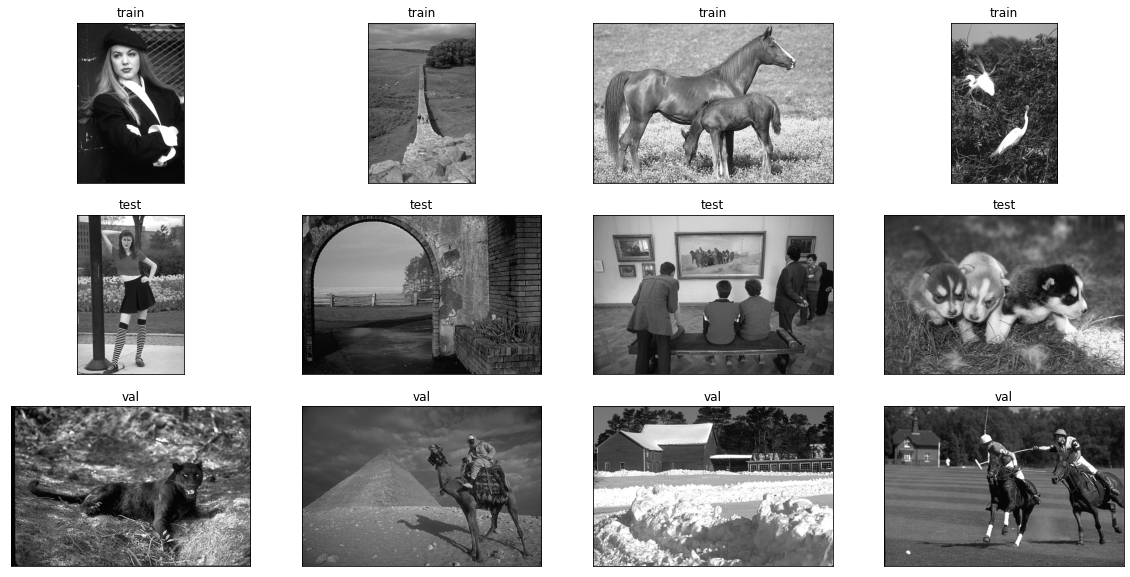

In [3]:
ncols = 4
nrows = 3

fig,axs = plt.subplots(nrows = nrows,ncols = ncols,figsize=(20,10))
test = glob('../images/test/*.jpg')
train = glob('../images/train/*.jpg')
val = glob('../images/val/*.jpg')

imgs = [train,test,val]
titles = ['train','test','val']

for i in range(len(imgs)):
    for j in range(ncols):
        _ = np.random.choice(imgs[i])
        axs[i,j].imshow(cv2.imread(_,cv2.IMREAD_GRAYSCALE),cmap = 'gray')
        axs[i,j].set_xticks([])
        axs[i,j].set_xticklabels([])
        axs[i,j].set_yticks([])
        axs[i,j].set_yticklabels([])
        axs[i,j].set_title(titles[i])
        
        
plt.show()

# Blur

In [4]:
def open_frame_gauss(frame_num,var=1):
    input_path = frame_num
    
    img = np.asarray(cv2.cvtColor(cv2.imread(input_path), cv2.COLOR_BGR2GRAY), dtype=np.float32)
    img = cv2.resize(img,(CROP,CROP))
    input_channel = img/np.amax(img)
    gausBlur = cv2.blur(input_channel, (var,var)) 
    gausBlur = gausBlur/np.amax(gausBlur)
    
    return input_channel, gausBlur



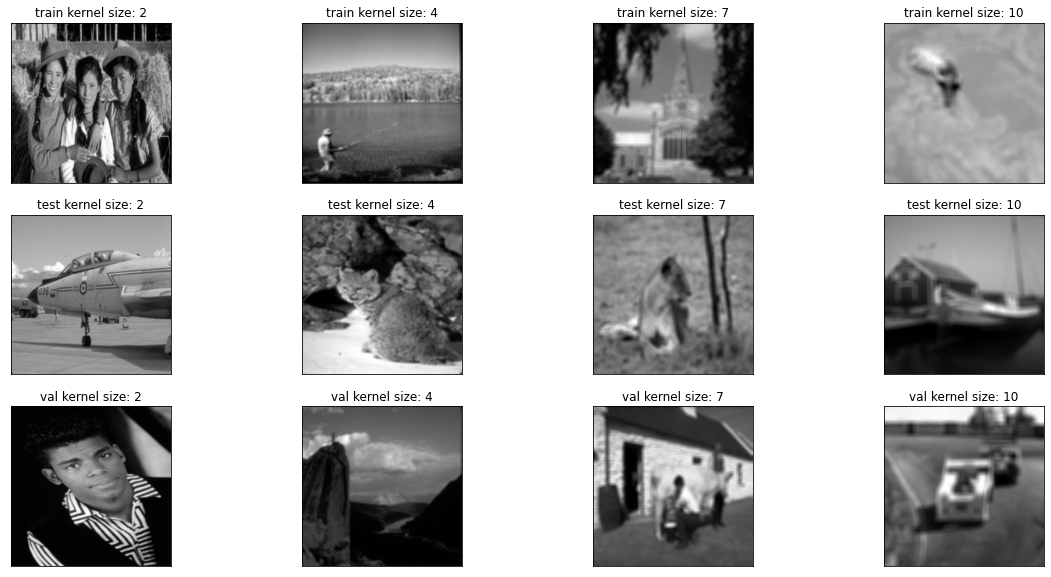

In [5]:
ncols = 4
nrows = 3

fig,axs = plt.subplots(nrows = nrows,ncols = ncols,figsize=(20,10))
test = glob('../images/test/*.jpg')
train = glob('../images/train/*.jpg')
val = glob('../images/val/*.jpg')

imgs = [train,test,val]
titles = ['train','test','val']
var = np.asarray(np.linspace(2,10,ncols),dtype='int')

for i in range(len(imgs)):
    for j in range(ncols):
        _ = np.random.choice(imgs[i])
        im = open_frame_gauss(_,var[j])
        axs[i,j].imshow(im[1],cmap = 'gray')
        axs[i,j].set_xticks([])
        axs[i,j].set_xticklabels([])
        axs[i,j].set_yticks([])
        axs[i,j].set_yticklabels([])
        axs[i,j].set_title(f'{titles[i]} kernel size: {var[j]}')
        
        
plt.show()

## option 1

100%|███████████████████████████████████████| 10/10 [7:24:51<00:00, 2669.15s/it]


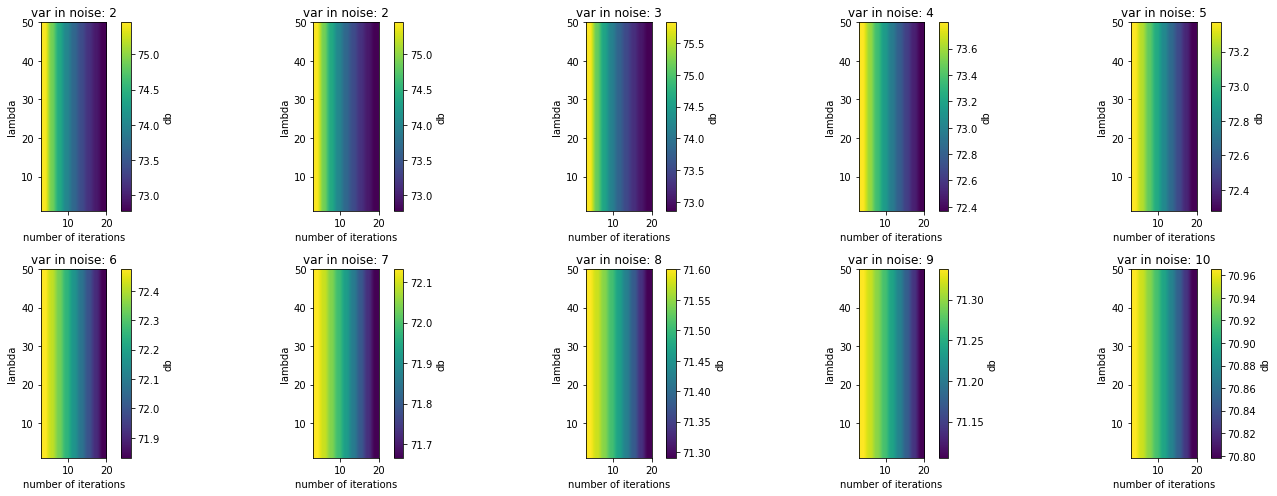

In [35]:
ncols,nrows = 5,2
var = np.asarray(np.linspace(2,10,ncols*nrows),dtype='int')
V = []
for j in tqdm(range(len(var))):
    K = []
    for lambd in np.linspace(1,50,100):
        psnr = []
        for it in np.arange(3,20,2):
            er = []
            for _ in train:
                x,y = open_frame_gauss(_,var[j])
                y = anisodiff(y,niter=it,lambd=lambd)
                er.append(cv2.PSNR(x,y))
            psnr.append(np.mean(er))
        K.append(psnr)
    V.append(K)
    
np.save('/home/joel/nci-storage/fly_group_behavior/scripts/PeronaMalik/thesis/11_oct/option_1_blur.npy',np.array(V))


fig,axs = plt.subplots(ncols=ncols,nrows=nrows,figsize=(20,7))

for i in range(len(V)):
    im = axs[i//ncols,i%ncols].imshow(V[i],extent=[3,20,1,50])
    plt.colorbar(im,ax=axs[i//ncols,i%ncols],label='db')
    axs[i//ncols,i%ncols].set_xlabel('number of iterations')
    axs[i//ncols,i%ncols].set_ylabel('lambda')
    axs[i//ncols,i%ncols].set_title(f'var in noise: {var[i]}')
    
plt.tight_layout()
plt.show()

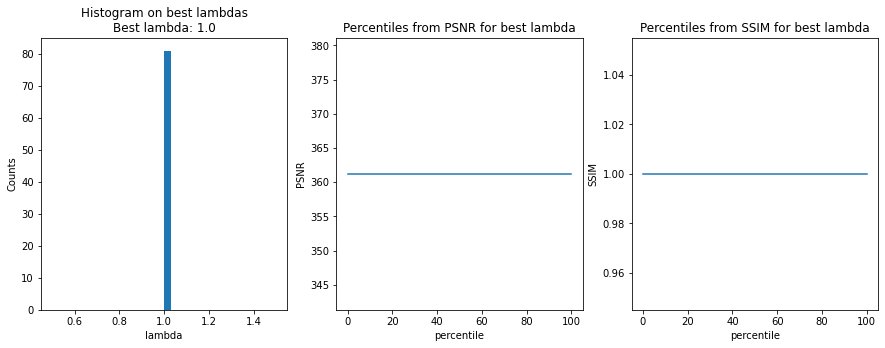

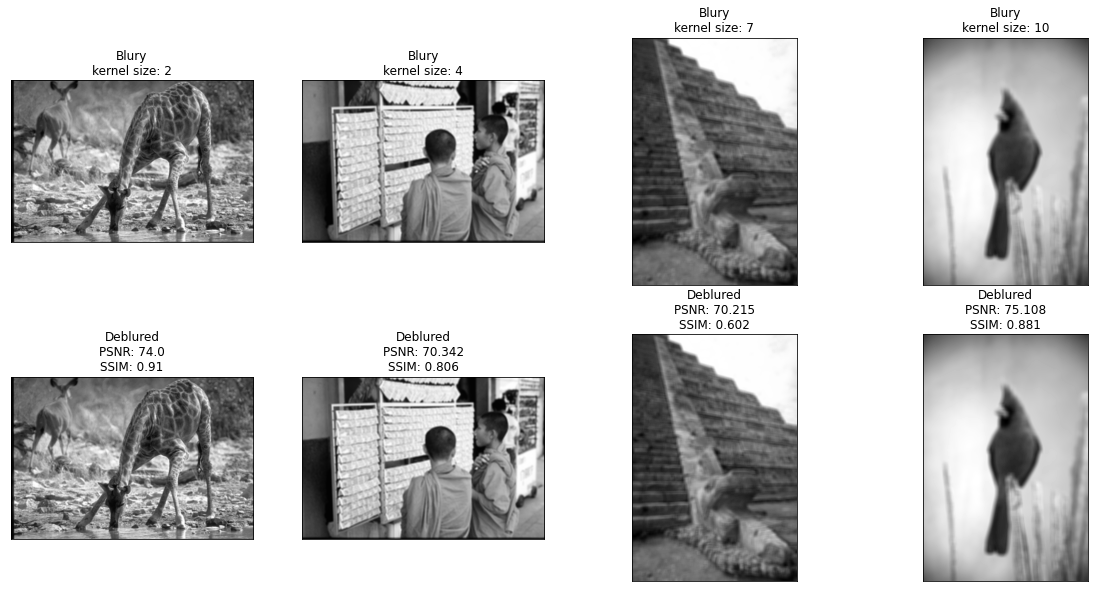

In [36]:
psnr,ssim = [],[]
for _ in test:
    im = open_frame_gauss(_)
    psnr.append(cv2.PSNR(im[0],anisodiff(im[1],option=1)))
    ssim.append(SSIM(im[0],anisodiff(im[1],option=1)))

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.hist(np.linspace(1,50,100)[np.argmax(V[1:],axis=1).flatten()],bins=30)
hist = np.histogram(np.linspace(1,50,100)[np.argmax(V[1:],axis=1).flatten()],bins=30)
best = np.trunc(1e3*hist[1][np.argmax(hist[0])])/1e3
plt.xlabel('lambda')
plt.ylabel('Counts')
plt.title(f'Histogram on best lambdas\nBest lambda: {best}')

plt.subplot(132)
plt.plot(np.percentile(psnr,q=np.arange(0,101,1)))
plt.xlabel('percentile')
plt.ylabel('PSNR')
plt.title('Percentiles from PSNR for best lambda')

plt.subplot(133)
plt.plot(np.percentile(ssim,q=np.arange(0,101,1)))
plt.xlabel('percentile')
plt.ylabel('SSIM')
plt.title('Percentiles from SSIM for best lambda')

plt.show()

ncols = 4
nrows = 2

fig,axs = plt.subplots(nrows = nrows,ncols = ncols,figsize=(20,10))
test = glob('../images/test/*.jpg')
train = glob('../images/train/*.jpg')
val = glob('../images/val/*.jpg')

var = np.asarray(np.linspace(2,10,ncols),dtype='int')


for j in range(ncols):
    _ = np.random.choice(test)
    im = open_frame_gauss(_,var[j])
    denoised = anisodiff(im[1],niter=1,lambd=best,option=1)
    axs[0,j].imshow(im[1],cmap = 'gray')
    axs[0,j].set_xticks([])
    axs[0,j].set_xticklabels([])
    axs[0,j].set_yticks([])
    axs[0,j].set_yticklabels([])
    axs[0,j].set_title(f'Blury\nkernel size: {var[j]}')
    
    axs[1,j].imshow(denoised,cmap = 'gray')
    axs[1,j].set_xticks([])
    axs[1,j].set_xticklabels([])
    axs[1,j].set_yticks([])
    axs[1,j].set_yticklabels([])
    axs[1,j].set_title(f'Deblured\nPSNR: {np.trunc(1e3*cv2.PSNR(im[0],denoised))/1e3}\nSSIM: {np.trunc(1e3*SSIM(im[0],denoised))/1e3}')
        
        
plt.show()

## option 2

100%|███████████████████████████████████████| 10/10 [5:32:14<00:00, 1993.42s/it]


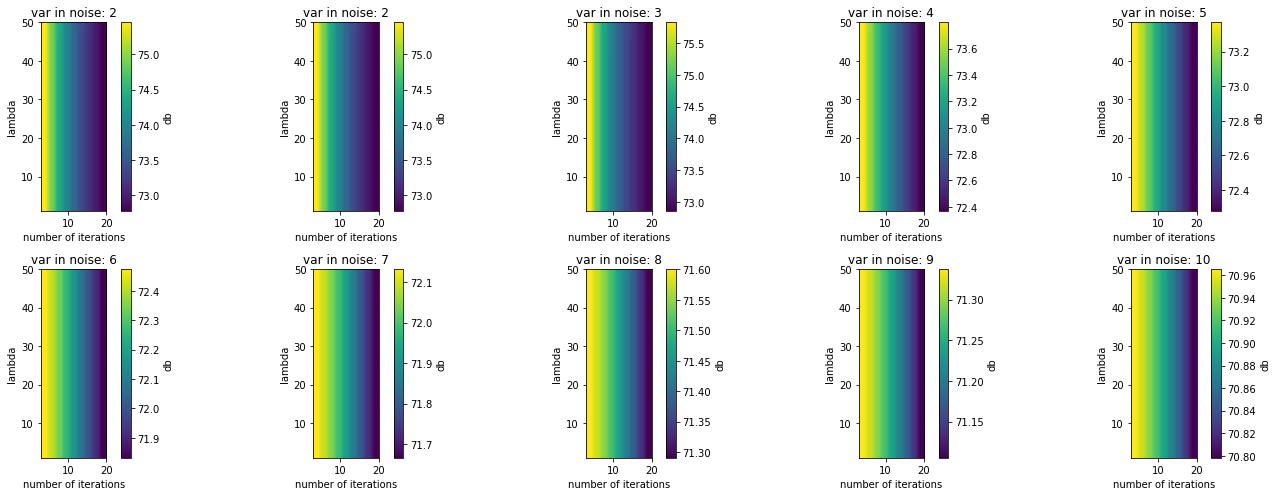

In [37]:
ncols,nrows = 5,2

var = np.asarray(np.linspace(2,10,ncols*nrows),dtype='int')
V = []
for j in tqdm(range(len(var))):
    K = []
    for lambd in np.linspace(1,50,100):
        psnr = []
        for it in np.arange(3,20,2):
            er = []
            for _ in train:
                x,y = open_frame_gauss(_,var[j])
                y = anisodiff(y,niter=it,lambd=lambd,option=2)
                er.append(cv2.PSNR(x,y))
            psnr.append(np.mean(er))
        K.append(psnr)
    V.append(K)
    
np.save('/home/joel/nci-storage/fly_group_behavior/scripts/PeronaMalik/thesis/11_oct/option_2_blur.npy',np.array(V))


fig,axs = plt.subplots(ncols=ncols,nrows=nrows,figsize=(20,7))

for i in range(len(V)):
    im = axs[i//ncols,i%ncols].imshow(V[i],extent=[3,20,1,50])
    plt.colorbar(im,ax=axs[i//ncols,i%ncols],label='db')
    axs[i//ncols,i%ncols].set_xlabel('number of iterations')
    axs[i//ncols,i%ncols].set_ylabel('lambda')
    axs[i//ncols,i%ncols].set_title(f'var in noise: {var[i]}')
    
plt.tight_layout()
plt.show()

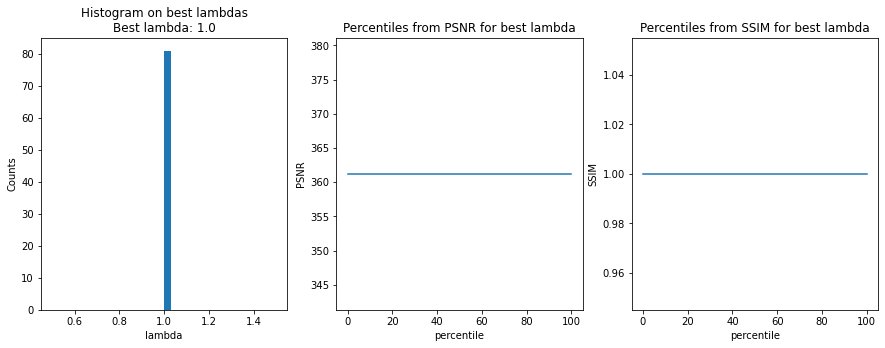

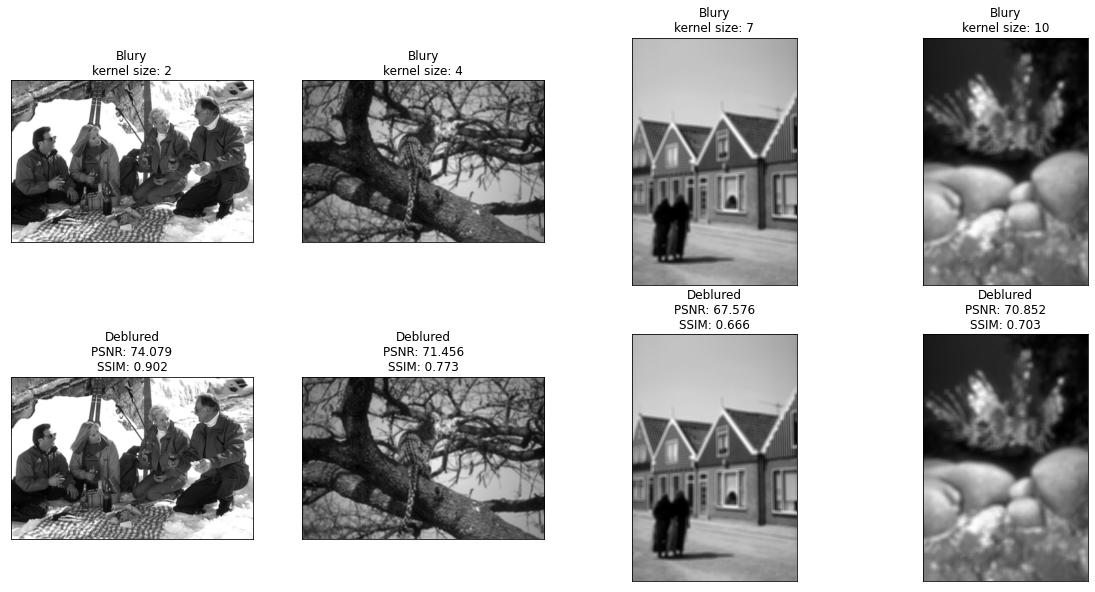

In [38]:
psnr,ssim = [],[]
for _ in test:
    im = open_frame_gauss(_)
    psnr.append(cv2.PSNR(im[0],anisodiff(im[1],option=2)))
    ssim.append(SSIM(im[0],anisodiff(im[1],option=2)))

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.hist(np.linspace(1,50,100)[np.argmax(V[1:],axis=1).flatten()],bins=30)
hist = np.histogram(np.linspace(1,50,100)[np.argmax(V[1:],axis=1).flatten()],bins=30)
best = np.trunc(1e3*hist[1][np.argmax(hist[0])])/1e3
plt.xlabel('lambda')
plt.ylabel('Counts')
plt.title(f'Histogram on best lambdas\nBest lambda: {best}')

plt.subplot(132)
plt.plot(np.percentile(psnr,q=np.arange(0,101,1)))
plt.xlabel('percentile')
plt.ylabel('PSNR')
plt.title('Percentiles from PSNR for best lambda')

plt.subplot(133)
plt.plot(np.percentile(ssim,q=np.arange(0,101,1)))
plt.xlabel('percentile')
plt.ylabel('SSIM')
plt.title('Percentiles from SSIM for best lambda')

plt.show()

ncols = 4
nrows = 2

fig,axs = plt.subplots(nrows = nrows,ncols = ncols,figsize=(20,10))
test = glob('../images/test/*.jpg')
train = glob('../images/train/*.jpg')
val = glob('../images/val/*.jpg')

var = np.asarray(np.linspace(2,10,ncols),dtype='int')

for j in range(ncols):
    _ = np.random.choice(test)
    im = open_frame_gauss(_,var[j])
    denoised = anisodiff(im[1],niter=1,lambd=best,option=2)
    axs[0,j].imshow(im[1],cmap = 'gray')
    axs[0,j].set_xticks([])
    axs[0,j].set_xticklabels([])
    axs[0,j].set_yticks([])
    axs[0,j].set_yticklabels([])
    axs[0,j].set_title(f'Blury\nkernel size: {var[j]}')
    
    axs[1,j].imshow(denoised,cmap = 'gray')
    axs[1,j].set_xticks([])
    axs[1,j].set_xticklabels([])
    axs[1,j].set_yticks([])
    axs[1,j].set_yticklabels([])
    axs[1,j].set_title(f'Deblured\nPSNR: {np.trunc(1e3*cv2.PSNR(im[0],denoised))/1e3}\nSSIM: {np.trunc(1e3*SSIM(im[0],denoised))/1e3}')
        
        
plt.show()

# Neural networks

In [11]:
def divergence_x(x):
    return(x[:,1:]-x[:,:-1])

def divergence_y(x):
    return(x[:,:,1:]-x[:,:,:-1])

def make_model(input_shape, option=1, num_classes=2):
    inputs = keras.Input(shape=input_shape)
    
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [16,32,64,128]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
        
    activation = "linear"
    units = 1

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    outputs = tf.keras.layers.Lambda(lambda z: tf.math.pow(z,-2))(outputs)
    

    dx = tf.keras.layers.Lambda(divergence_x)(inputs)
    dy = tf.keras.layers.Lambda(divergence_y)(inputs)

    dx = tf.keras.layers.Lambda(lambda z:tf.image.resize(z,[CROP,CROP]))(dx)
    dy = tf.keras.layers.Lambda(lambda z:tf.image.resize(z,[CROP,CROP]))(dy)
    
    dx2 = tf.keras.layers.Lambda(lambda z:tf.math.pow(z,2))(dx)
    dy2 = tf.keras.layers.Lambda(lambda z:tf.math.pow(z,2))(dy)
    
    norm = tf.keras.layers.add([dx2,dy2])
    
    if option == 1:
        coeff = tf.keras.layers.multiply([outputs,norm])
        coeff = tf.keras.layers.Lambda(lambda z: tf.math.exp(-z))(coeff)
    elif option == 2:
        coeff = tf.keras.layers.multiply([outputs,norm])
        coeff = tf.keras.layers.Lambda(lambda z: 1./(1. + z))(coeff)
        
    outputs_x = tf.keras.layers.multiply([coeff,dx])
    outputs_y = tf.keras.layers.multiply([coeff,dy])

    outputs_x = tf.keras.layers.Lambda(divergence_x)(outputs_x)
    outputs_y = tf.keras.layers.Lambda(divergence_y)(outputs_y)

    outputs_x = tf.keras.layers.Lambda(lambda x:tf.image.resize(x,[CROP,CROP]))(outputs_x)
    outputs_y = tf.keras.layers.Lambda(lambda x:tf.image.resize(x,[CROP,CROP]))(outputs_y)

    outputs = tf.keras.layers.add([outputs_x,outputs_y])
    outputs = tf.keras.layers.Conv2D(1,1,activation="linear",padding="same")(outputs)
    outputs = tf.keras.layers.add([outputs,inputs])
    
    return keras.Model(inputs, outputs)

image_size = (CROP,CROP)
model = make_model(input_shape=image_size + (1,), num_classes=2)
#keras.utils.plot_model(model, show_shapes=True)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 128, 128, 32  320         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_11 (BatchN  (None, 128, 128, 32  128        ['conv2d_7[0][0]']               
 ormalization)                  )                                                           

 Conv2D)                                                                                          
                                                                                                  
 batch_normalization_18 (BatchN  (None, 32, 32, 64)  256         ['separable_conv2d_14[0][0]']    
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 16, 16, 64)  0           ['batch_normalization_18[0][0]'] 
                                                                                                  
 conv2d_11 (Conv2D)             (None, 16, 16, 64)   2112        ['add_8[0][0]']                  
                                                                                                  
 add_9 (Add)                    (None, 16, 16, 64)   0           ['max_pooling2d_6[0][0]',        
          

 lambda_22 (Lambda)             (None, 256, 256, 1)  0           ['lambda_20[0][0]']              
                                                                                                  
 lambda_23 (Lambda)             (None, 256, 256, 1)  0           ['lambda_21[0][0]']              
                                                                                                  
 add_12 (Add)                   (None, 256, 256, 1)  0           ['lambda_22[0][0]',              
                                                                  'lambda_23[0][0]']              
                                                                                                  
 conv2d_13 (Conv2D)             (None, 256, 256, 1)  2           ['add_12[0][0]']                 
                                                                                                  
 add_13 (Add)                   (None, 256, 256, 1)  0           ['conv2d_13[0][0]',              
          

In [20]:
var = 10
X_train,Y_train = [],[]

for _ in train:
    im = open_frame_gauss(_,var=var)
    X_train.append(np.expand_dims(im[1],axis=-1))
    Y_train.append(np.expand_dims(im[0],axis=-1))
    
X_test,Y_test = [],[]

for _ in test:
    im = open_frame_gauss(_,var=var)
    X_test.append(np.expand_dims(im[1],axis=-1))
    Y_test.append(np.expand_dims(im[0],axis=-1))
    
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [12]:
epochs = 50

callbacks = [tf.keras.callbacks.ModelCheckpoint(
    filepath= f"./checkpoints/debluring_{var}",
    save_weights_only=True,
    monitor='val_loss',
    mode='max',
    save_best_only=True),
]

def loss_function(y_true, y_pred):
    return 1./tf.image.psnr(y_true,y_pred,max_val = 1.)

def metric(y_true, y_pred):
    return tf.image.ssim(y_true,y_pred,max_val = 1.)

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=loss_function,
    metrics=[metric],
)

history = model.fit(
    x=X_train,y=Y_train, epochs=epochs, callbacks=callbacks, validation_data=(X_test,Y_test),
)

np.save(f"./history/debluring_{var}.npy",np.array(list(history.history.values())))

Epoch 1/50
7/7 [==============================] - 37s 5s/step - loss: 0.0515 - metric: 0.5262 - val_loss: 0.0506 - val_metric: 0.5145
Epoch 2/50
7/7 [==============================] - 36s 5s/step - loss: 0.0509 - metric: 0.5270 - val_loss: 0.0502 - val_metric: 0.5152
Epoch 3/50
7/7 [==============================] - 36s 5s/step - loss: 0.0505 - metric: 0.5269 - val_loss: 0.0499 - val_metric: 0.5152
Epoch 4/50
7/7 [==============================] - 36s 5s/step - loss: 0.0503 - metric: 0.5257 - val_loss: 0.0497 - val_metric: 0.5147
Epoch 5/50
7/7 [==============================] - 36s 5s/step - loss: 0.0501 - metric: 0.5240 - val_loss: 0.0495 - val_metric: 0.5137
Epoch 6/50
7/7 [==============================] - 36s 5s/step - loss: 0.0500 - metric: 0.5220 - val_loss: 0.0495 - val_metric: 0.5124
Epoch 7/50
7/7 [==============================] - 36s 5s/step - loss: 0.0499 - metric: 0.5197 - val_loss: 0.0494 - val_metric: 0.5112
Epoch 8/50
7/7 [==============================] - 36s 5s/step 

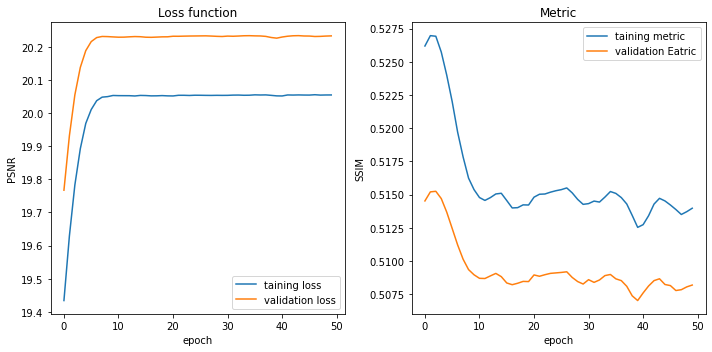

In [23]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.plot(1/np.array(history.history["loss"]),label = "taining loss")
plt.plot(1/np.array(history.history["val_loss"]),label = "validation loss")
plt.title("Loss function")
plt.xlabel("epoch")
plt.ylabel("PSNR")
plt.legend()

plt.subplot(122)
plt.plot(history.history["metric"],label = "taining metric")
plt.plot(history.history["val_metric"],label = "validation Eatric")
plt.title("Metric")
plt.xlabel("epoch")
plt.ylabel("SSIM")
plt.legend()

plt.tight_layout()
plt.show()

In [51]:
ncols,nrows = 4,4
X_val,Y_val = [],[]

for _ in val:
    im = open_frame_gauss(_,var=var)
    X_val.append(np.expand_dims(im[1],axis=-1))
    Y_val.append(np.expand_dims(im[0],axis=-1))
    
X_val,Y_val = np.array(X_val),np.array(Y_val)

inputs = keras.Input(shape=image_size + (1,))
visualization = tf.keras.models.Model(model.input,model.layers[-10].output)

p = model(X_val)
vis = np.squeeze(visualization(X_val))

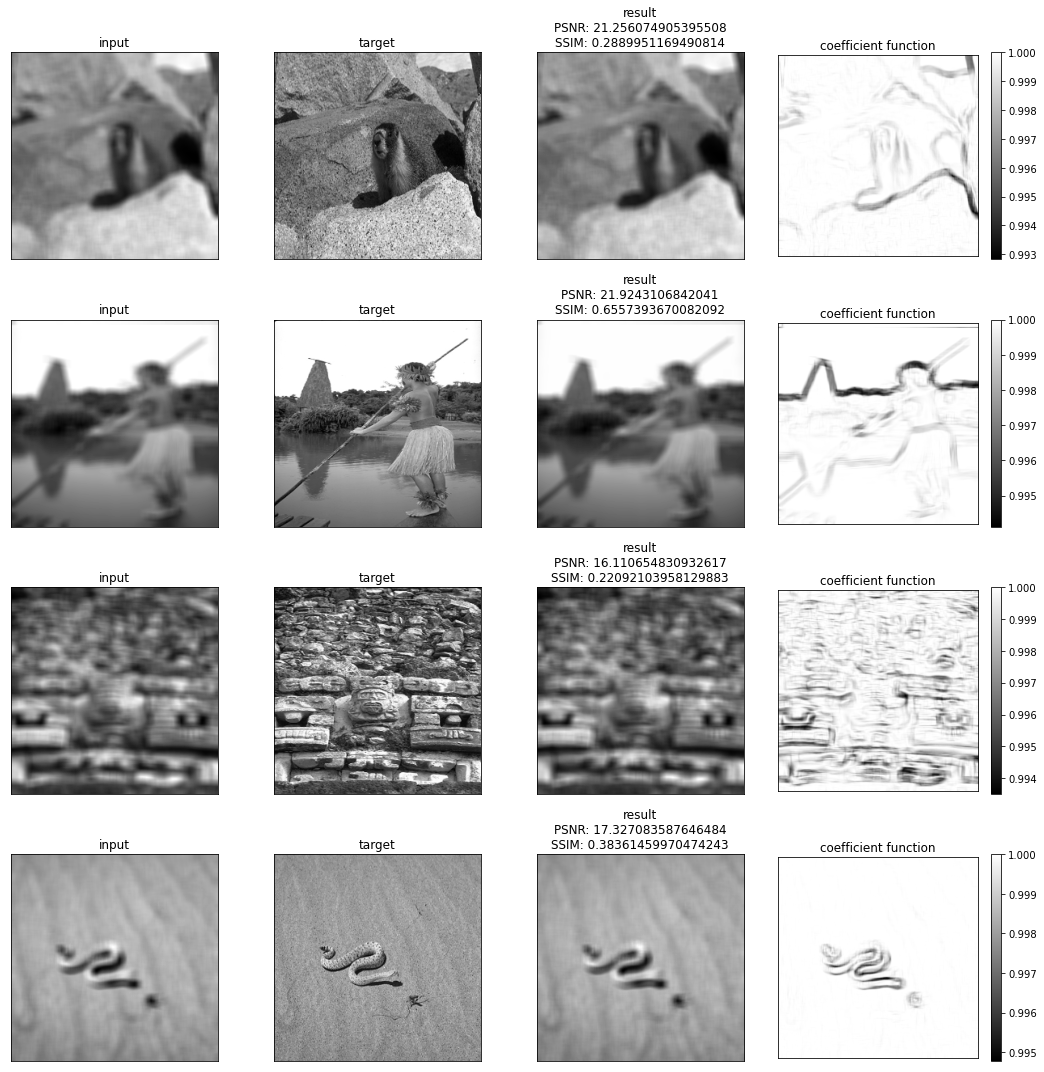

In [54]:
fig,axs = plt.subplots(ncols=ncols,nrows=nrows,figsize=(15,15))

for i in range(nrows):
    _ = np.random.choice(len(p))
    
    axs[i,0].imshow(X_val[_],cmap="gray")
    axs[i,0].set_title("input")
    axs[i,0].set_xticks([])
    axs[i,0].set_xticklabels([])
    axs[i,0].set_yticks([])
    axs[i,0].set_yticklabels([])
    axs[i,1].imshow(Y_val[_],cmap="gray")
    axs[i,1].set_title("target")
    axs[i,1].set_xticks([])
    axs[i,1].set_xticklabels([])
    axs[i,1].set_yticks([])
    axs[i,1].set_yticklabels([])
    axs[i,2].imshow(p[_],cmap="gray")
    psnr = tf.image.psnr(Y_val[_],p[_],max_val=1)
    ssim = tf.image.ssim(Y_val[_],p[_],max_val=1)
    axs[i,2].set_title(f"result\nPSNR: {psnr}\nSSIM: {ssim}")
    axs[i,2].set_xticks([])
    axs[i,2].set_xticklabels([])
    axs[i,2].set_yticks([])
    axs[i,2].set_yticklabels([])
    im = axs[i,3].imshow(vis[_],cmap="gray")
    plt.colorbar(im,ax=axs[i,3])
    axs[i,3].set_title("coefficient function")
    axs[i,3].set_xticks([])
    axs[i,3].set_xticklabels([])
    axs[i,3].set_yticks([])
    axs[i,3].set_yticklabels([])
    
plt.tight_layout()
plt.show()